In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
imtkaggleteam_dental_radiography_path = kagglehub.dataset_download('imtkaggleteam/dental-radiography')

print('Data source import complete.')


(done in colab)

In [ ]:
#libraries

import os
import numpy as np
import pandas as pd

#machine learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [ ]:
!nvidia-smi

Wed Jan  1 15:58:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
#Parameters
num_classes = 4
img_height = 64
img_width = 64
batch_size = 16
epochs = 20
learning_rate = 0.001

TRAIN_DIR = '/kaggle/input/dental-radiography/train'  # Path to your images
TEST_DIR = '/kaggle/input/dental-radiography/valid'
TRAINING_CSV = '/kaggle/input/dental-radiography/train/_annotations.csv'
TEST_CSV = '/kaggle/input/dental-radiography/valid/_annotations.csv'

In [ ]:
# Load CSVs
train_df = pd.read_csv(TRAINING_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df['filename'] = train_df['filename'] #so we can get all images from filename column in csv
test_df['filename'] = test_df['filename']

In [ ]:
# Print the first few rows and info of the dataframes to verify the structure
print("Training DataFrame:")
print(train_df.head())
print(train_df.info())

print("\nTesting DataFrame:")
print(test_df.head())
print(test_df.info())

Training DataFrame:
                                           filename  width  height     class  \
0  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
1  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256  Fillings   
2  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
3  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
4  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   

   xmin  ymin  xmax  ymax  
0   175   116   206   153  
1   170   109   189   133  
2   221   124   257   178  
3   302   126   329   175  
4   335   114   360   154  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8030 entries, 0 to 8029
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8030 non-null   object
 1   width     8030 non-null   int64 
 2   height    8030 non-null   int64 
 3   class     8030 non-null   obje

In [ ]:
# Define the label columns
#label_column = 'class'

In [ ]:
# Image augmentation setup for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [ ]:
# No augmentation for test data, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images from dataframe

#we feed the dataset into the augmentor and load it in to train_generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="class",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 8030 validated image filenames belonging to 4 classes.


In [ ]:
# Flow test images (no augmentation)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col="filename",
    y_col="class",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 780 validated image filenames belonging to 4 classes.


In [ ]:
# Verify that the generators are producing data
print("\nVerifying generators:")
x, y = next(train_generator)
print(f"Training data shape: {x.shape}, Labels shape: {y.shape}")

from collections import Counter
import numpy as np

# Assuming `y_train` contains class labels
class_counts = Counter(y[1])
print("Class distribution:", class_counts)

# Calculate total number of samples
total_samples = sum(class_counts.values())

num_classes = len(class_counts)
class_weight = {
    class_id: total_samples / (num_classes * count)
    for class_id, count in class_counts.items()
}
print("Class weights:", class_weight)


x, y = next(test_generator)
print(f"Testing data shape: {x.shape}, Labels shape: {y.shape}")


Verifying generators:
Training data shape: (16, 64, 64, 3), Labels shape: (16, 4)
Class distribution: Counter({0.0: 3, 1.0: 1})
Class weights: {0.0: 0.6666666666666666, 1.0: 2.0}
Testing data shape: (16, 64, 64, 3), Labels shape: (16, 4)


In [ ]:

# Define the CNN model architecture
model = tf.keras.Sequential([
    # Input and scaling
    tf.keras.layers.Rescaling(scale=1./255, input_shape=[img_height, img_width, 3]),

    # First convolutional block
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Flatten the output
    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(num_classes, activation="sigmoid")  # Changed to sigmoid for multi-label
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
###################################### UPDATED MODEL ########################################################

# Define the CNN model architecture
model = tf.keras.Sequential([
    # Input and scaling
    tf.keras.layers.Rescaling(scale=1./255, input_shape=[img_height, img_width, 3]),

    # First convolutional block
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Fourth convolutional block (new)
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Fifth convolutional block (new)
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Flatten the output
    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(4, activation="sigmoid")  # Sigmoid for multi-label
])

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",  # Changed to binary_crossentropy for multi-label
              metrics=['accuracy'])


In [ ]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,945,828 (22.68 MB)

 Trainable params: 5,939,940 (22.66 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    class_weight=class_weight
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


502/502 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.3907 - loss: 2.6279 - val_accuracy: 0.6923 - val_loss: 0.9638
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.6286 - loss: 1.2981 - val_accuracy: 0.6923 - val_loss: 0.9426
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.6527 - loss: 1.1610 - val_accuracy: 0.6923 - val_loss: 0.9117
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.6569 - loss: 1.1293 - val_accuracy: 0.6923 - val_loss: 0.9145
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.6506 - loss: 1.1165 - val_accuracy: 0.6923 - val_loss: 0.9223
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.6519 - loss: 1.1143 - val_accuracy: 0.6923 - val_loss: 0.9461
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.6547 - loss: 1.0976 - val_accuracy: 0.6923 - val_loss: 0.9397
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.6520 - loss: 1.0953 - val_accurac

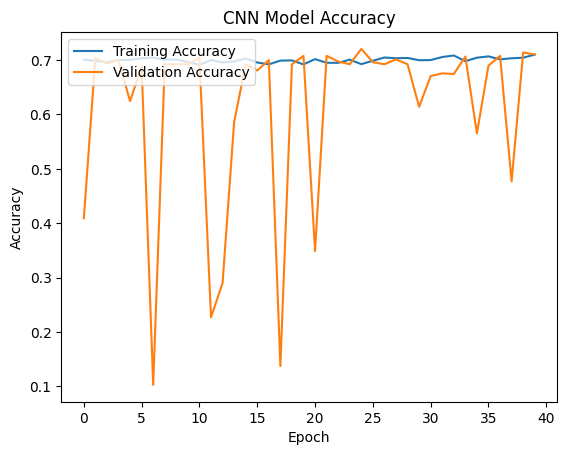

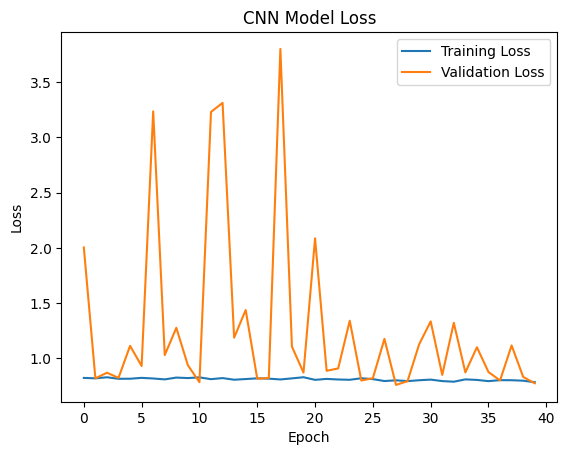

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.save('/kaggle/working/cnn_424.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the full model
loaded_model = load_model('/kaggle/working/cnn_424.h5')

# Set all layers to be trainable
for layer in loaded_model.layers:
    layer.trainable = True


In [ ]:
# Compile the model
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",  # Changed to binary_crossentropy for multi-label
              metrics=['accuracy'])

In [ ]:
history = loaded_model.fit(
    train_generator,
    epochs=40,
    validation_data=test_generator,
    class_weight=class_weight
)

Epoch 1/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 52s 73ms/step - accuracy: 0.7112 - loss: 0.8107 - val_accuracy: 0.4090 - val_loss: 2.0039
Epoch 2/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.6985 - loss: 0.8214 - val_accuracy: 0.7038 - val_loss: 0.8202
Epoch 3/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.7045 - loss: 0.8180 - val_accuracy: 0.6936 - val_loss: 0.8713
Epoch 4/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.7005 - loss: 0.8172 - val_accuracy: 0.7000 - val_loss: 0.8246
Epoch 5/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.6973 - loss: 0.8205 - val_accuracy: 0.6244 - val_loss: 1.1143
Epoch 6/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.7079 - loss: 0.8195 - val_accuracy: 0.6885 - val_loss: 0.9322
Epoch 7/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7029 - loss: 0.8266 - val_accuracy: 0.1026 - val_loss: 3.2349
Epoch 8/40
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.6907 - loss: 0.8241 - 

In [ ]:
loaded_model.save('/kaggle/working/cnn_424.h5')

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

NameError: name 'l' is not defined